In [1]:
import sympy
import itertools
from mira.metamodel import *
from mira.modeling import Model
from mira.modeling.askenet.petrinet import AskeNetPetriNetModel
from mira.modeling.viz import GraphicalModel

def sanity_check_tm(tm: TemplateModel):
    assert tm.templates
    all_concept_names = set(tm.get_concepts_name_map())
    all_parameter_names = set(tm.parameters)
    all_symbols = all_concept_names | all_parameter_names | ({tm.time.name} if tm.time else set())
    for template in tm.templates:
        assert template.rate_law
        symbols = template.rate_law.args[0].free_symbols
        for symbol in symbols:
            assert symbol.name in all_symbols
    all_initial_names = {init.concept.name for init in tm.initials.values()}
    for concept in all_concept_names:
        assert concept in all_initial_names

Susceptible people are infected by the infectious class at a rate λI. Exposed individuals become infectious at a rate k. Infectious individuals recover at a rate δ and shed virus at a rate α × β, where α is the fecal load and β is the average viral shedding rate in Eq. (1). The time spent in the E and I classes are exponentially distributed with average duration of 1/k and 1/δ, respectively. γ is the viral degradation and loss rate in the sewer pipes, so only a fraction (1 − γ) of virus is detected in the wastewater sample. The expression for V follows directly from Eq

In [2]:
person_units = lambda: Unit(expression=sympy.Symbol('person'))
virus_units = lambda: Unit(expression=sympy.Symbol('virus'))
virus_per_gram_units = lambda: Unit(expression=sympy.Symbol('virus')/sympy.Symbol('gram'))
day_units = lambda: Unit(expression=sympy.Symbol('day'))
per_day_units = lambda: Unit(expression=1/sympy.Symbol('day'))
dimensionless_units = lambda: Unit(expression=sympy.Integer('1'))
gram_units = lambda: Unit(expression=sympy.Symbol('gram'))
per_day_per_person_units = lambda: Unit(expression=1/(sympy.Symbol('day')*sympy.Symbol('person')))

# See Table 1 of the paper
c = {
    'S': Concept(name='S', units=person_units(), identifiers={'ido': '0000514'}),
    'E': Concept(name='E', units=person_units(), identifiers={'apollosv': '0000154'}),
    'I': Concept(name='I', units=person_units(), identifiers={'ido': '0000511'}),
    'V': Concept(name='V', units=person_units(), identifiers={'vido': '0001331'}),
}


parameters = {
    'gamma': Parameter(name='gamma', value=None, units=per_day_units()),
    'delta': Parameter(name='delta', value=1/8, units=per_day_units()),
    'alpha': Parameter(name='alpha', value=500, units=gram_units(),
                       distribution=Distribution(type='Uniform1',
                                                 parameters={
                                                     'minimum': 51,
                                                     'maximum': 796
                                                 })),
    'lambda': Parameter(name='lambda', value=None, units=per_day_per_person_units()),
    'beta': Parameter(name='beta', value=None, units=virus_per_gram_units()),
    'k': Parameter(name='k', value=1/3, units=per_day_units()),
}

initials = {
    'S': Initial(concept=Concept(name='S'), value=2_300_000),
    'E': Initial(concept=Concept(name='E'), value=1000),
    'I': Initial(concept=Concept(name='I'), value=0),
    'V': Initial(concept=Concept(name='V'), value=0),
}

In [3]:
S, E, I, V, gamma, delta, alpha, lmbd, beta, k = \
    sympy.symbols('S E I V gamma delta alpha lambda beta k')

In [4]:
t1 = ControlledConversion(subject=c['S'],
                          outcome=c['E'],
                          controller=c['I'],
                          rate_law=S*I*lmbd)
t2 = NaturalConversion(subject=c['E'],
                       outcome=c['I'],
                       rate_law=k*E)
t3 = NaturalDegradation(subject=c['I'],
                       rate_law=delta*I)
t4 = ControlledProduction(outcome=c['V'],
                          controller=c['I'],
                          rate_law=alpha*beta*(1-gamma)*I)
templates = [t1, t2, t3, t4]
observables = {}
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 base model')
)
sanity_check_tm(tm)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario3_base.json')

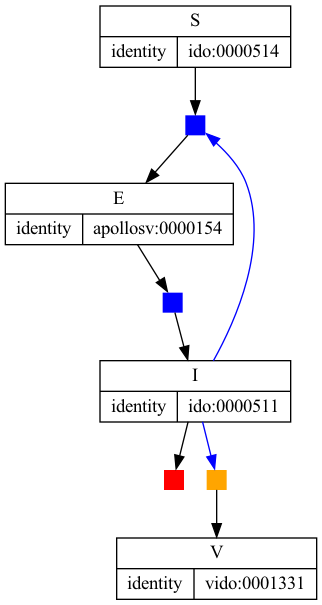

In [5]:
GraphicalModel.for_jupyter(tm)

In [6]:
c['C'] = Concept(name='C', units=person_units(), identifiers={'cemo': 'cumulative_cases'})

In [7]:
t5 = GroupedControlledProduction(
    outcome=c['C'],
    controllers=[c['S'], c['I']],
    rate_law=lmbd*S*I
)

In [8]:
templates = [t1, t2, t3, t4, t5]
observables = {}
initials['C'] = Initial(concept=Concept(name='C'), value=0)
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 model with cases')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario3_2.json')

In [9]:
c['D'] = Concept(name='D', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C15220'})
c['U'] = Concept(name='U', units=person_units(), identifiers={'ido': '0000511'},
                 context={'property': 'ncit:C113725'})

parameters['kappa'] = Parameter(name='kappa', value=0.1, units=dimensionless_units())
t6 = GroupedControlledProduction(
    outcome=c['D'],
    controllers=[c['S'], c['I']],
    rate_law=sympy.Symbol('kappa')*lmbd*S*I
)
t7 = GroupedControlledProduction(
    outcome=c['U'],
    controllers=[c['S'], c['I']],
    rate_law=(1-sympy.Symbol('kappa'))*lmbd*S*I
)

In [10]:
templates = [t1, t2, t3, t4, t5, t6, t7]
observables = {}
initials['D'] = Initial(concept=Concept(name='D'), value=0)
initials['U'] = Initial(concept=Concept(name='U'), value=0)
tm = TemplateModel(
    templates=templates,
    parameters=parameters,
    initials=initials,
    time=Time(name='t', units=day_units()),
    observables=observables,
    annotations=Annotations(name='Scenario 3 model with cases and detection')
)
AskeNetPetriNetModel(Model(tm)).to_json_file('eval_scenario3_3.json')

In [11]:
from mira.sources.askenet.petrinet import model_from_json_file
mm = model_from_json_file('eval_scenario3_3.json')

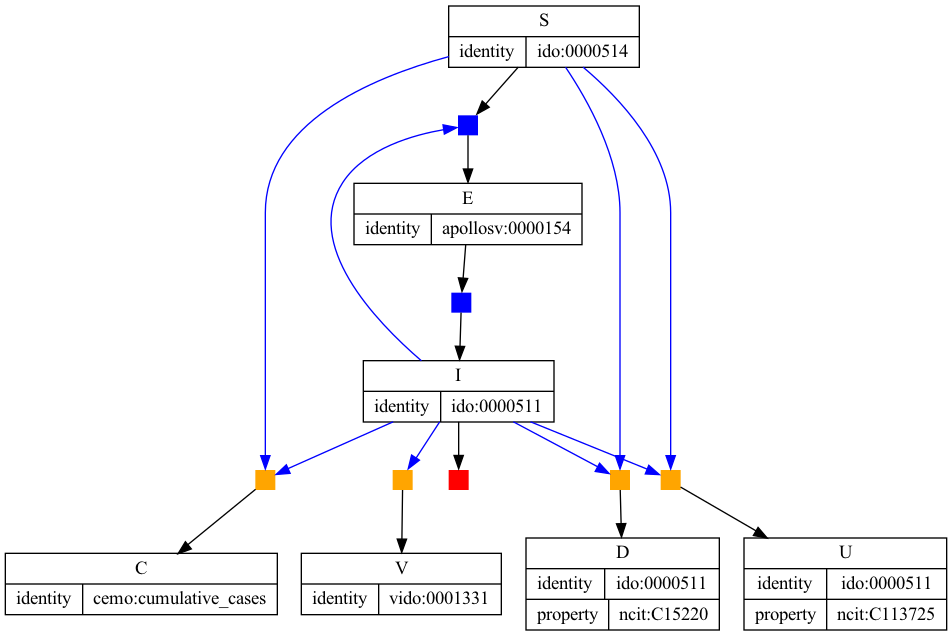

In [12]:
GraphicalModel.for_jupyter(tm)

In [13]:
for t in mm.templates:
    print(t)
    print()

rate_law=I*S*lambda name='t1' type='ControlledConversion' controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)) subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)) outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)) provenance=[]

rate_law=E*k name='t2' type='NaturalConversion' subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)) outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)) provenance=[]

rate_law=I*delta name='t3' type='NaturalDegradation' subject=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=U

In [14]:
from mira.sources.askenet.petrinet import model_from_json_file

In [15]:
model_from_json_file('eval_scenario3_3.json')

TemplateModel(templates=[ControlledConversion(rate_law=I*S*lambda, name='t1', type='ControlledConversion', controller=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), subject=Concept(name='S', display_name='S', description=None, identifiers={'ido': '0000514'}, context={}, units=Unit(expression=person)), outcome=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalConversion(rate_law=E*k, name='t2', type='NaturalConversion', subject=Concept(name='E', display_name='E', description=None, identifiers={'apollosv': '0000154'}, context={}, units=Unit(expression=person)), outcome=Concept(name='I', display_name='I', description=None, identifiers={'ido': '0000511'}, context={}, units=Unit(expression=person)), provenance=[]), NaturalDegradation(rate_law=I*delta, name='t3', type='NaturalDegradation', subject=Concep

In [16]:
Model(_15)

In [17]:
AskeNetPetriNetModel(Model(_15))

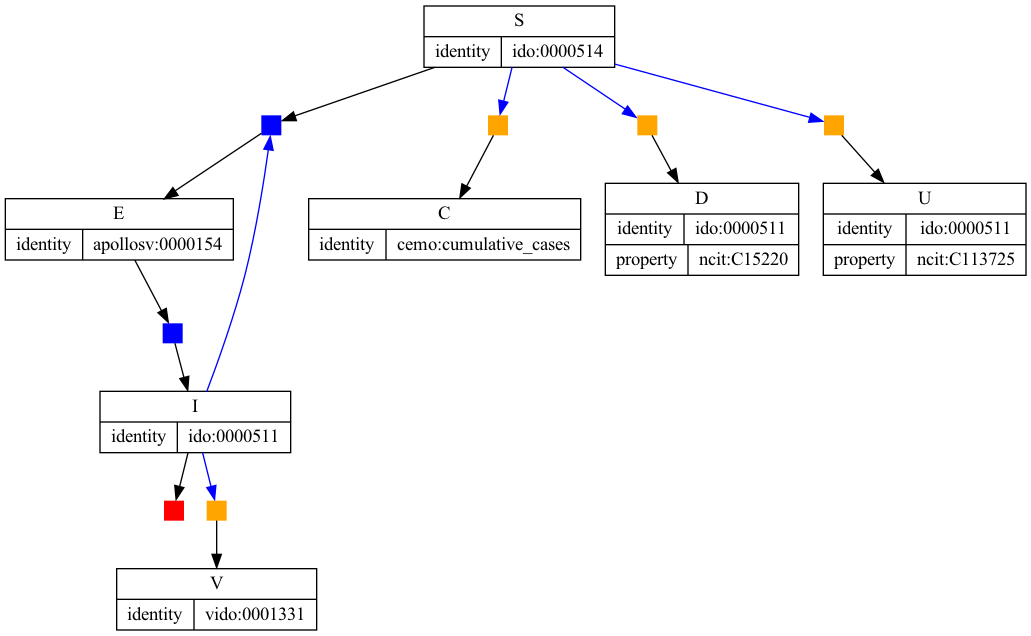

In [19]:
GraphicalModel.for_jupyter(_15)